In [ ]:
import re
from collections import Counter
import powerlaw
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
from scipy.stats import linregress


# ======= Step 1: Carica e tokenizza =======
warnings.filterwarnings("ignore")

with open("merged_horror_stories_lowtemp.txt", "r", encoding="utf-8") as f:
    text_horror_lowtemp = f.read().lower()
with open("merged_horror_stories1.txt", "r", encoding="utf-8") as f:
    text_horror= f.read().lower()

with open("merged_scientific_lowtemp.txt", "r", encoding="utf-8") as f:
    text_scientific_lowtemp = f.read().lower()
with open("merged_scientific.txt", "r", encoding="utf-8") as f:
    text_scientific= f.read().lower()

with open("merged_surreal_narrative_lowtemp.txt", "r", encoding="utf-8") as f:
    text_surreal_narrative_lowtemp = f.read().lower()
with open("merged_surreal_narrative_lowtemp.txt", "r", encoding="utf-8") as f:
    text_surreal_narrative= f.read().lower()

In [ ]:
def rank_frequs(text):
    # Tokenizzazione molto semplice: solo parole con lettere
    words = re.findall(r"\b[a-z]+\b", text)

    # Frequenza delle parole
    word_counts = Counter(words)
    #frequencies = list(word_counts.values())

    # ======= Step 2: Crea un DataFrame ordinato per frequenza =======
    word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
    word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)

    word_freq_df['rank'] = 1
    for i in range(1, len(word_freq_df)):
        if word_freq_df['frequency'][i] != word_freq_df['frequency'][i - 1]:
            word_freq_df['rank'][i] = word_freq_df['rank'][i - 1] + 1
        else: 
            word_freq_df['rank'][i] = word_freq_df['rank'][i -1]

    word_freq_df = word_freq_df[['rank', 'word', 'frequency']]
    word_freq_df['rel_freq'] = word_freq_df['frequency']/sum(word_freq_df['frequency'])

    return(word_freq_df)

In [ ]:
# Applica la funzione rank_frequs a tutti i testi
df_horror = rank_frequs(text_horror)
df_horror_lowtemp = rank_frequs(text_horror_lowtemp)

df_scientific = rank_frequs(text_scientific)
df_scientific_lowtemp = rank_frequs(text_scientific_lowtemp)

df_surreal_narrative = rank_frequs(text_surreal_narrative)
df_surreal_narrative_lowtemp = rank_frequs(text_surreal_narrative_lowtemp)

In [ ]:
df_horror.tail()

,rank,word,frequency,rel_freq
7985,462,risks,1,0.000002
7986,462,kindling,1,0.000002
7987,462,lain,1,0.000002
7988,462,colliding,1,0.000002
7989,462,conclusion,1,0.000002


: 

In [55]:
df_scientific.tail()

,rank,word,frequency,rel_freq
10689,392,resection,1,0.000002
10690,392,struggle,1,0.000002
10691,392,resected,1,0.000002
10692,392,rpa,1,0.000002
10693,392,corona,1,0.000002


Before fitting the line: cut the tails!

The long tail is noisy:

- Contains many hapax legomena (words with frequency = 1).

- These flatten the curve in log-log space and distort the slope.

Zipf’s law is most valid for the head:

- The first few thousand ranks typically show a clean power-law behavior.

- The tail often deviates due to sampling artifacts, rare words, or topic-specific vocabulary.

Fitting the whole distribution underestimates R² and inflates α.

In [ ]:
# ======= Zipf fitting con chopping + lunghezza prima/dopo =======

# Horror
len_horror_before = len(df_horror)
fit_horror = powerlaw.Fit(df_horror['frequency'], discrete=True)
xmin_horror = fit_horror.power_law.xmin
df_horror = df_horror[df_horror['frequency'] >= xmin_horror]
len_horror_after = len(df_horror)
print("Horror - xmin:", xmin_horror, " | Before:", len_horror_before, " | After:", len_horror_after)

# Horror Low Temp
len_horror_low_before = len(df_horror_lowtemp)
fit_horror_low = powerlaw.Fit(df_horror_lowtemp['frequency'], discrete=True)
xmin_horror_low = fit_horror_low.power_law.xmin
df_horror_lowtemp = df_horror_lowtemp[df_horror_lowtemp['frequency'] >= xmin_horror_low]
len_horror_low_after = len(df_horror_lowtemp)
print("Horror Low Temp - xmin:", xmin_horror_low, " | Before:", len_horror_low_before, " | After:", len_horror_low_after)

# Scientific
len_scientific_before = len(df_scientific)
fit_scientific = powerlaw.Fit(df_scientific['frequency'], discrete=True)
xmin_scientific = fit_scientific.power_law.xmin
df_scientific = df_scientific[df_scientific['frequency'] >= xmin_scientific]
len_scientific_after = len(df_scientific)
print("Scientific - xmin:", xmin_scientific, " | Before:", len_scientific_before, " | After:", len_scientific_after)

# Scientific Low Temp
len_scientific_low_before = len(df_scientific_lowtemp)
fit_scientific_low = powerlaw.Fit(df_scientific_lowtemp['frequency'], discrete=True)
xmin_scientific_low = fit_scientific_low.power_law.xmin
df_scientific_lowtemp = df_scientific_lowtemp[df_scientific_lowtemp['frequency'] >= xmin_scientific_low]
len_scientific_low_after = len(df_scientific_lowtemp)
print("Scientific Low Temp - xmin:", xmin_scientific_low, " | Before:", len_scientific_low_before, " | After:", len_scientific_low_after)

# Surreal Narrative
len_surreal_before = len(df_surreal_narrative)
fit_surreal = powerlaw.Fit(df_surreal_narrative['frequency'], discrete=True)
xmin_surreal = fit_surreal.power_law.xmin
df_surreal_narrative = df_surreal_narrative[df_surreal_narrative['frequency'] >= xmin_surreal]
len_surreal_after = len(df_surreal_narrative)
print("Surreal Narrative - xmin:", xmin_surreal, " | Before:", len_surreal_before, " | After:", len_surreal_after)

# Surreal Narrative Low Temp
len_surreal_low_before = len(df_surreal_narrative_lowtemp)
fit_surreal_low = powerlaw.Fit(df_surreal_narrative_lowtemp['frequency'], discrete=True)
xmin_surreal_low = fit_surreal_low.power_law.xmin
df_surreal_narrative_lowtemp = df_surreal_narrative_lowtemp[df_surreal_narrative_lowtemp['frequency'] >= xmin_surreal_low]
len_surreal_low_after = len(df_surreal_narrative_lowtemp)
print("Surreal Narrative Low Temp - xmin:", xmin_surreal_low, " | Before:", len_surreal_low_before, " | After:", len_surreal_low_after)

Calculating best minimal value for power law fit
Suggested xmin horror: 183.0
Calculating best minimal value for power law fit
Suggested xmin scientific: 120.0


In [ ]:
def estimate_zipf_alpha(df):
    log_r = np.log(df['rank'])
    log_f = np.log(df['frequency'])
    slope, intercept, r_value, p_value, std_err = linregress(log_r, log_f)
    return -slope, r_value**2  # Negative slope = Zipf α

# ======= Stima α e R² per tutti i testi =======

alpha_horror, r2_horror = estimate_zipf_alpha(df_horror)
alpha_horror_low, r2_horror_low = estimate_zipf_alpha(df_horror_lowtemp)

alpha_scientific, r2_scientific = estimate_zipf_alpha(df_scientific)
alpha_scientific_low, r2_scientific_low = estimate_zipf_alpha(df_scientific_lowtemp)

alpha_surreal, r2_surreal = estimate_zipf_alpha(df_surreal_narrative)
alpha_surreal_low, r2_surreal_low = estimate_zipf_alpha(df_surreal_narrative_lowtemp)

# ======= Stampa risultati =======

print("Horror Text:")
print("Estimated α (Zipf):", alpha_horror)
print("R²:", r2_horror)

print("\nHorror Text (Low Temp):")
print("Estimated α (Zipf):", alpha_horror_low)
print("R²:", r2_horror_low)

print("\nScientific Text:")
print("Estimated α (Zipf):", alpha_scientific)
print("R²:", r2_scientific)

print("\nScientific Text (Low Temp):")
print("Estimated α (Zipf):", alpha_scientific_low)
print("R²:", r2_scientific_low)

print("\nSurreal Narrative:")
print("Estimated α (Zipf):", alpha_surreal)
print("R²:", r2_surreal)

print("\nSurreal Narrative (Low Temp):")
print("Estimated α (Zipf):", alpha_surreal_low)
print("R²:", r2_surreal_low)

Horror Text:
Estimated α (Zipf): 1.0133011955981779
R²: 0.990263930864679

Scientific Text:
Estimated α (Zipf): 1.0135295825577983
R²: 0.9896019496044767


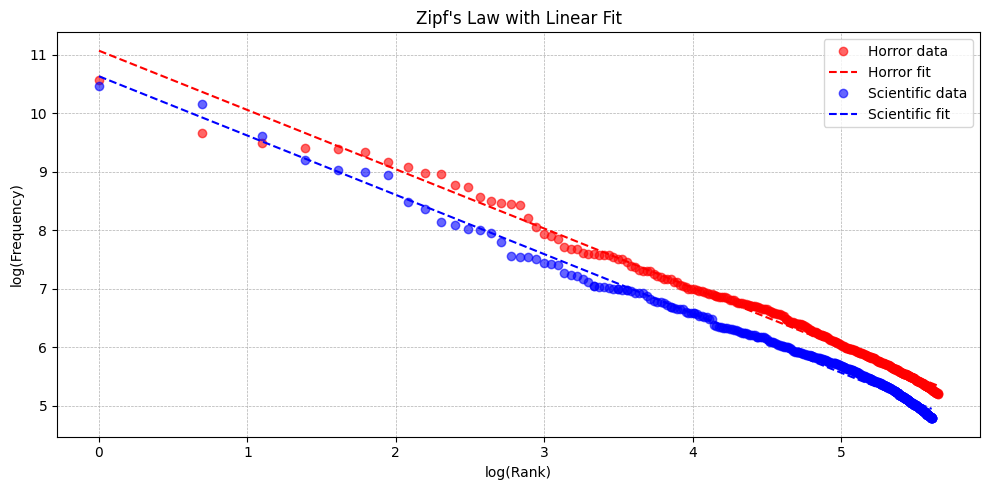

In [ ]:
# Get the frequency dataframe for the horror text
df_horror = rank_frequs(text_horror)

# Select top 50 words by frequency
top_50 = df_horror.head(20).set_index('word')

# Create plot
y_pos = np.arange(len(top_50))
plt.figure(figsize=(14, 8))
plt.bar(y_pos, top_50['frequency'], align='center', alpha=0.7, color='darkred')
plt.xticks(y_pos, top_50.index, rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 Words')
plt.title('Top 50 Most Frequent Words in Merged Horror Stories')
plt.tight_layout()
plt.show()

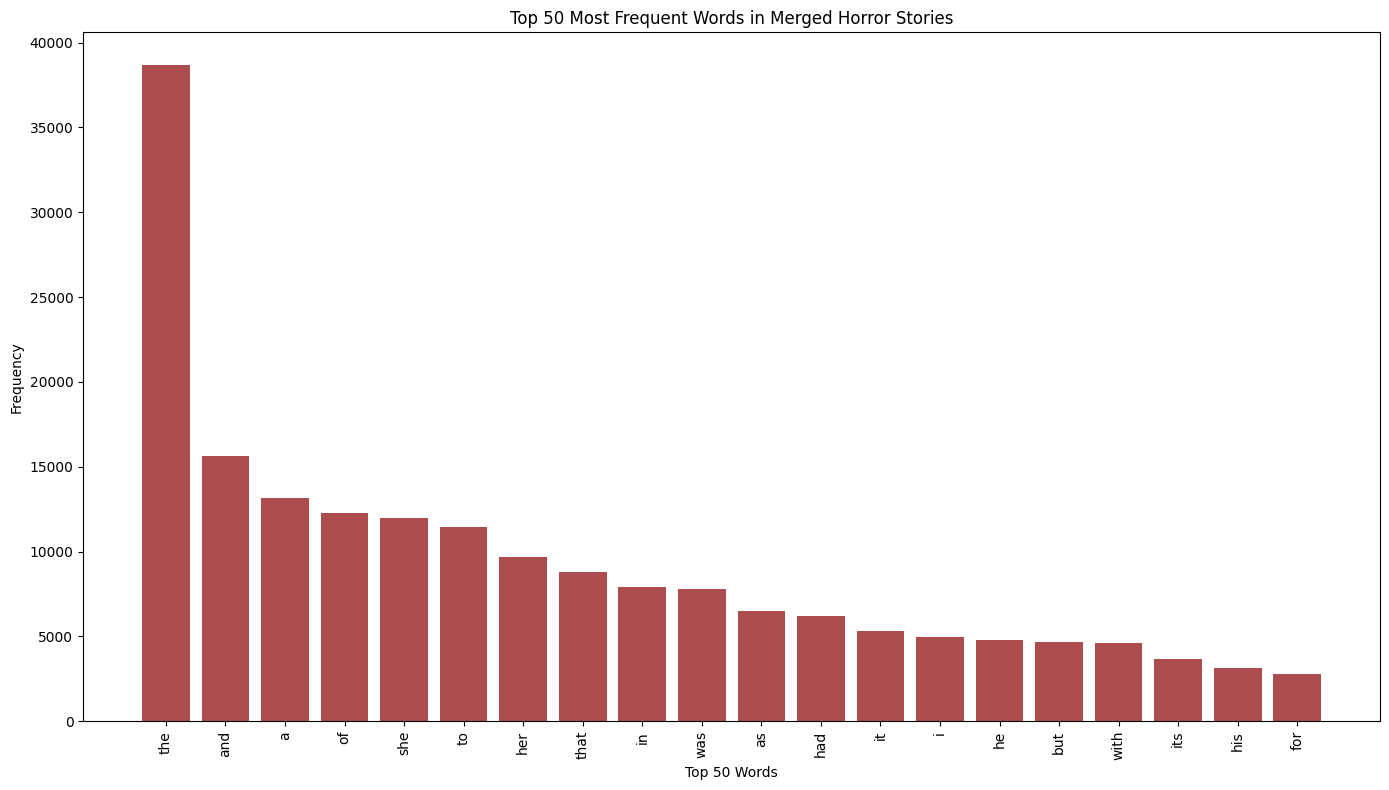

In [ ]:
def plot_zipf(df, ax, title_text, color='blue', xmin=None, 
              text_length_before=None, text_length_after=None, show_ylabel=True, show_xlabel=True):
    from numpy import argsort, logspace

    counts = df['frequency'].values
    tokens = df['word'].values
    indices = argsort(-counts)
    frequencies = counts[indices]
    tokens = tokens[indices]
    ranks = np.arange(1, len(frequencies) + 1)

    log_r = np.log(ranks)
    log_f = np.log(frequencies)
    slope, intercept, *_ = linregress(log_r, log_f)
    alpha_empirical = -slope

    # Plot dati
    ax.loglog(ranks, frequencies, marker=".", color=color, alpha=0.7, label="Data")

    # Linea Zipf teorica (α = 1)
    ax.plot([1, ranks[-1]], [frequencies[0], frequencies[0] / ranks[-1]], 
            color='red', linestyle='--', label=r"Zipf α = 1")

    # Fit empirico
    fit_line = np.exp(intercept + slope * log_r)
    ax.plot(ranks, fit_line, linestyle='--', color=color, label=f"Fit α ≈ {alpha_empirical:.2f}")

    # Annotazioni: top 8 + log-spaced (fino al 40%)
    for n in range(min(7, len(frequencies))):
        ax.text(ranks[n], frequencies[n], " " + tokens[n],
                verticalalignment="bottom", horizontalalignment="left", fontsize=12)

    if len(frequencies) > 8:
        start = 8
        end = int(len(frequencies) * 0.4)
        extra_indices = np.logspace(np.log10(start), np.log10(end), 10).astype(int)
        extra_indices = np.unique(extra_indices)
        for n in extra_indices:
            if n < len(frequencies):
                ax.text(ranks[n], frequencies[n], " " + tokens[n],
                        verticalalignment="bottom", horizontalalignment="left", fontsize=10)

    # Box informativo (in basso a sinistra)
    info_text = (
        f"Words before chopping: {text_length_before}\n"
        f"Words after chopping: {text_length_after}\n"
        f"$\\mathregular{{xmin}}$: {xmin}"
    )
    ax.text(0.02, 0.02, info_text, transform=ax.transAxes,
            fontsize=15, ha='left', va='bottom',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

    # Titolo e assi con font maggiore
    ax.set_title(title_text, fontsize=15)
    if show_xlabel:
        ax.set_xlabel("Rank of token (log)", fontsize=15)

    if show_ylabel:
        ax.set_ylabel("Frequency (log)", fontsize=15)


    # Griglia e legenda
    ax.grid(True, which="both", ls="--", lw=0.4)
    ax.legend(fontsize=15)



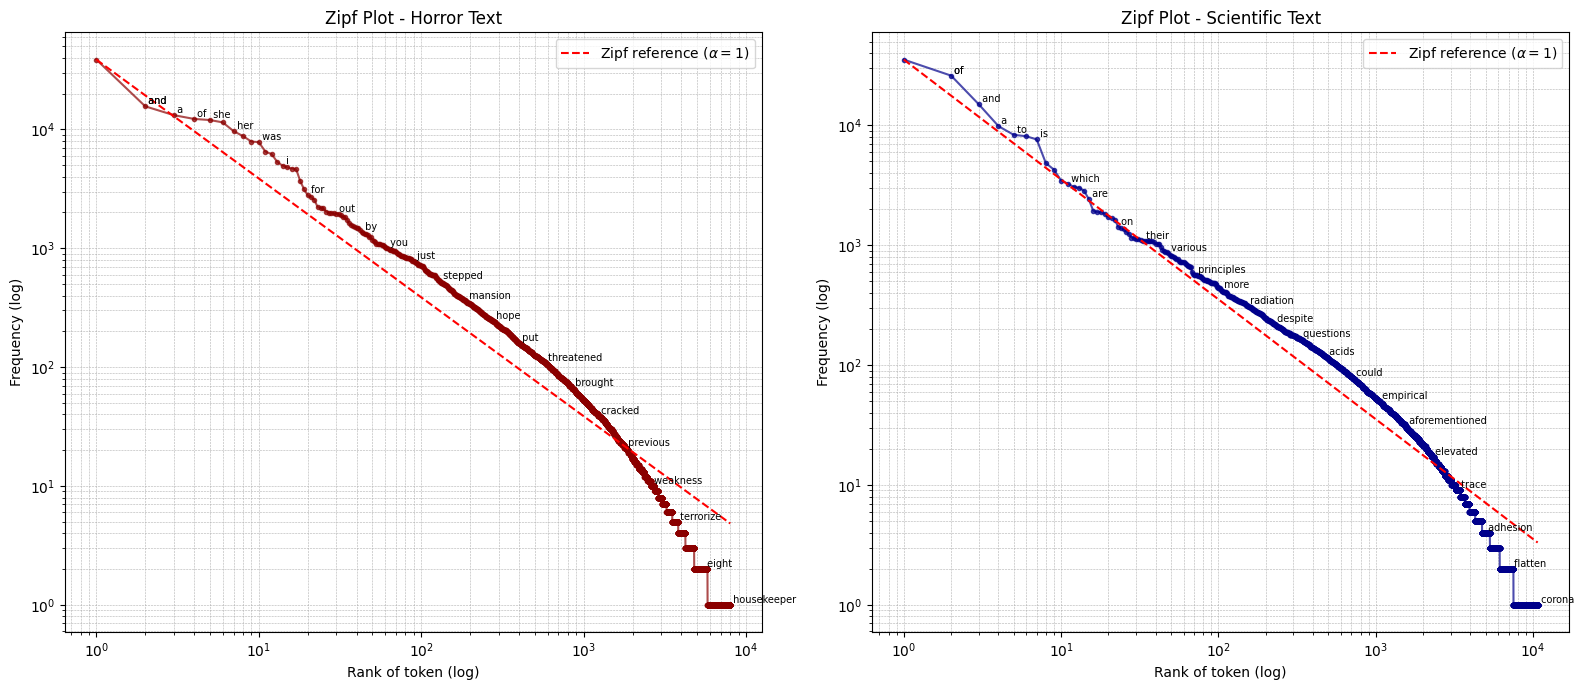

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12))

plot_zipf(df_horror, axes[0, 0], "Zipf Plot - Horror", color='darkred',
          xmin=xmin_horror, text_length_before=len_horror_before, text_length_after=len_horror_after,
          show_ylabel=True, show_xlabel=False)

plot_zipf(df_horror_lowtemp, axes[0, 1], "Zipf Plot - Horror (Low Temp)", color='lightcoral',
          xmin=xmin_horror_low, text_length_before=len_horror_low_before, text_length_after=len_horror_low_after,
          show_ylabel=False, show_xlabel=False)

plot_zipf(df_scientific, axes[1, 0], "Zipf Plot - Scientific", color='darkblue',
          xmin=xmin_scientific, text_length_before=len_scientific_before, text_length_after=len_scientific_after,
          show_ylabel=True, show_xlabel=False)

plot_zipf(df_scientific_lowtemp, axes[1, 1], "Zipf Plot - Scientific (Low Temp)", color='skyblue',
          xmin=xmin_scientific_low, text_length_before=len_scientific_low_before, text_length_after=len_scientific_low_after,
          show_ylabel=False, show_xlabel=False)

plot_zipf(df_surreal_narrative, axes[2, 0], "Zipf Plot - Surreal Narrative", color='darkgreen',
          xmin=xmin_surreal, text_length_before=len_surreal_before, text_length_after=len_surreal_after,
          show_ylabel=True, show_xlabel=True)

plot_zipf(df_surreal_narrative_lowtemp, axes[2, 1], "Zipf Plot - Surreal Narrative (Low Temp)", color='limegreen',
          xmin=xmin_surreal_low, text_length_before=len_surreal_low_before, text_length_after=len_surreal_low_after,
          show_ylabel=False, show_xlabel=True)

plt.tight_layout()
plt.show()




In [ ]:
from sklearn.utils import resample

def bootstrap_alpha(df, n=1000):
    alphas = []
    for _ in range(n):
        sample = resample(df)
        log_r = np.log(sample['rank'])
        log_f = np.log(sample['frequency'])
        slope, _, _, _, _ = linregress(log_r, log_f)
        alphas.append(-slope)
    return np.percentile(alphas, [2.5, 97.5])


In [ ]:
ci_horror, alpha_horror_mean = bootstrap_alpha(df_horror)
ci_horror_low, alpha_horror_low_mean = bootstrap_alpha(df_horror_lowtemp)

print("Horror α (mean):", alpha_horror_mean)
print("Horror α 95% CI:", ci_horror)

print("Horror Low Temp α (mean):", alpha_horror_low_mean)
print("Horror Low Temp α 95% CI:", ci_horror_low)
